# Tension computation in Chess

## Version 18/04/2025
## Adamo Cerioli


In [1]:
!pip install python-chess
!pip install --upgrade matplotlib networkx

import chess
import chess.pgn
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import SVG, display
import chess.svg
import chardet




reds  = ["#ff6d00", "#d50000"]  # rosso puro e arancione acceso
blues = ["#00b8d4", "#2962ff"]  # blu intenso e turchese brillante
greys = ["#e0e0e0", "#ffffff"]  # bianco, grigio molto chiaro
greys = ["black", "#ffffff"]


# Function for computing the interaction graph for a given color, with pawn capturing rules applied
def compute_interactions_for_color(board, color_turn):
    G = nx.Graph()
    piece_positions = {square: board.piece_at(square) for square in chess.SQUARES if board.piece_at(square)}
    
    board_copy = board.copy()
    board_copy.turn = color_turn
    
    all_nodes = []
    
    for square_a, piece_a in piece_positions.items():
        
        if piece_a.color == color_turn:
            node_a = f"{piece_a.symbol()}{chess.square_name(square_a)}"  # Include position in node name
            all_nodes.append(chess.square_name(square_a))
            for square_b, piece_b in piece_positions.items():
                if square_a != square_b:
                    node_b = f"{piece_b.symbol()}{chess.square_name(square_b)}"  # Include position in node name
                    all_nodes.append(chess.square_name(square_b))
                    
                    # Defense link (same color)
                    if (piece_a.color == piece_b.color) & (piece_b.piece_type != chess.KING):
                    #if (piece_a.color == piece_b.color): #& (piece_b.piece_type != chess.KING):
                        
                        board_copy.turn = not color_turn
            
                        #possible_moves = [moves for moves in board_copy.legal_moves if moves.from_square == square_a]
                        possible_moves = [moves for moves in board_copy.legal_moves]
                        arrival_squares = [chess.square_name(move.to_square) for move in possible_moves]
            
                        board_copy.turn = color_turn
                        
                        if chess.square_name(square_b) not in arrival_squares:
                            continue
                        
                        board_copy.remove_piece_at(square_b)
                        
                        if piece_a.color == chess.WHITE:
                            # Se il pezzo rimosso è bianco, metti un pedone nero
                            board_copy.set_piece_at(square_b, chess.Piece(chess.PAWN, chess.BLACK))
                        else:
                            # Se il pezzo rimosso è nero, metti un pedone bianco
                            board_copy.set_piece_at(square_b, chess.Piece(chess.PAWN, chess.WHITE))
                            
                        if piece_a.piece_type == chess.PAWN:
                            if piece_b:  # Ensure that there's an enemy piece to capture
                                if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                    G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                                    G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                    if G.has_edge(node_a, node_b):
                                        G.add_edge(node_a, node_b, weight=2, color=blues[0] if color_turn == chess.WHITE else blues[1])
                                    else:
                                        G.add_edge(node_a, node_b, weight=1, color=blues[0] if color_turn == chess.WHITE else blues[1])
                                    #G.add_edge(node_a, node_b, color=blues[0] if color_turn == chess.WHITE else blues[1])
                        else:
                            if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                                G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                if G.has_edge(node_a, node_b):
                                    G.add_edge(node_a, node_b, weight=2, color=blues[0] if color_turn == chess.WHITE else blues[1])
                                else:
                                    G.add_edge(node_a, node_b, weight=1, color=blues[0] if color_turn == chess.WHITE else blues[1])
                                #G.add_edge(node_a, node_b, color=blues[0] if color_turn == chess.WHITE else blues[1])
                        
                        board_copy.remove_piece_at(square_b)
                        board_copy.set_piece_at(square_b, piece_b)

                    # Attack link (different color)
                    elif piece_a.color != piece_b.color:
                        # Special rule for pawns: can only capture diagonally if an enemy piece is present
                        if piece_a.piece_type == chess.PAWN:
                            if piece_b:  # Ensure that there's an enemy piece to capture
                                if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                    G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                                    G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                    
                                    # test doppio attacco
                                    
                                    board_copy.turn = not color_turn
                                    
                                    if chess.Move(from_square=square_b, to_square=square_a) in board_copy.legal_moves:
                                        G.add_edge(node_a, node_b, weight=2, color=reds[0] if color_turn == chess.WHITE else reds[1])
                                    else:
                                        G.add_edge(node_a, node_b, weight=1, color=reds[0] if color_turn == chess.WHITE else reds[1])
                                    
                                    board_copy.turn = color_turn
                                    
                                    #G.add_edge(node_a, node_b, color=reds[0] if color_turn == chess.WHITE else reds[1])
                        else:  # For non-pawn pieces, follow the usual logic
                            if chess.Move(from_square=square_a, to_square=square_b) in board_copy.legal_moves:
                                G.add_node(node_a, color=greys[1] if node_a[0].isupper() else greys[0])
                                G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                
                                board_copy.turn = not color_turn
                                    
                                if chess.Move(from_square=square_b, to_square=square_a) in board_copy.legal_moves:
                                    G.add_edge(node_a, node_b, weight=2, color=reds[0] if color_turn == chess.WHITE else reds[1])
                                else:
                                    G.add_edge(node_a, node_b, weight=1, color=reds[0] if color_turn == chess.WHITE else reds[1])
                                    
                                board_copy.turn = color_turn
                                
                                
                                #G.add_edge(node_a, node_b, color=reds[0] if color_turn == chess.WHITE else reds[1])
            
    for square_a, piece_a in piece_positions.items():
        

        
        if piece_a.color != color_turn: 
            

                
            board_copy.turn = not color_turn
            
            possible_moves = [moves for moves in board_copy.legal_moves if moves.from_square == square_a]
            arrival_squares = [chess.square_name(move.to_square) for move in possible_moves]
            movements_no_attack_defense = [x for x in arrival_squares if x not in all_nodes]
            
            board_copy.turn = color_turn
            
            
            for moves in movements_no_attack_defense:
            
                board_copy.remove_piece_at(square_a)
                new_square_a = chess.parse_square(moves)
                board_copy.set_piece_at(new_square_a, piece_a)
                
                for square_b, piece_b in piece_positions.items():
                    node_b = f"{piece_b.symbol()}{chess.square_name(square_b)}"  # Include position in node name
                    if piece_a.color != piece_b.color:
                        if piece_b.piece_type == chess.PAWN:
                            if new_square_a:
                                if chess.Move(from_square=square_b, to_square=new_square_a) in board_copy.legal_moves:
                                    G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                    node_c = f"{moves}"
                                    G.add_node(node_c, color="#D2A679")
                                    G.add_edge(node_b, node_c, weight=1, color='lightblue' if color_turn == chess.WHITE else 'lightgreen')
                        else:
                            if chess.Move(from_square=square_b, to_square=new_square_a) in board_copy.legal_moves:
                                G.add_node(node_b, color=greys[1] if node_b[0].isupper() else greys[0])
                                node_c = f"{moves}"
                                G.add_node(node_c, color="#D2A679")
                                G.add_edge(node_b, node_c, weight=1, color='lightblue' if color_turn == chess.WHITE else 'lightgreen')
                
                board_copy.remove_piece_at(new_square_a)
                board_copy.set_piece_at(square_a, piece_a)
            
            
    return G



# Function to compute the full interaction graph
def compute_full_interaction_graph(board):
    G_white = compute_interactions_for_color(board, chess.WHITE)
    G_black = compute_interactions_for_color(board, chess.BLACK)
    G_full = nx.compose(G_white, G_black)
    return G_full

# Function to check if a piece is under attack
def is_piece_under_attack(board, square, color):
    return bool(list(board.attackers(not color, square)))


# Function to process a single game and compute fragility score over time
def process_single_game_max_eigenvalue(game):
    board = game.board()
    values = []
    board_states_before_move = []  # Store the board state **before** the move at each ply
    board_states_after_move = []   # Store the board state **after** the move at each ply
    moves = []  # To store the moves made
    pieces_making_moves = []  # To store the piece making each move
    key_pieces_under_attack = []  # To store the key piece under attack for each ply

    for move in game.mainline_moves():
        # Store the piece making the move before pushing the move
        piece_making_move = board.piece_at(move.from_square)
        piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
        pieces_making_moves.append(piece_symbol)  # Store the piece symbol

        board_states_before_move.append(board.copy())  # Store board **before** the move
        board.push(move)  # Make the move
        board_states_after_move.append(board.copy())   # Store board **after** the move
        moves.append(move)  # Store the move

        # Compute the full interaction graph
        G_full = compute_full_interaction_graph(board)
        
        try:
            A = nx.adjacency_matrix(G_full).todense()

            eigenvalues = np.linalg.eigvals(A)

            max_eigenvalue = np.max(np.real(eigenvalues))
        
        except:
            max_eigenvalue = 0

        values.append(max_eigenvalue)


    # Return both board states (before and after) and the interaction graph for that state
    return values




# Test for a single game

[1.847759065022574, 2.0000000000000027, 2.0000000000000027, 2.594400373744131, 1.9318516525781344, 1.931851652578139, 1.931851652578139, 3.002197139122235, 3.002197139122235, 3.0021971391222357, 3.0021971391222357, 3.002197139122236, 3.0603541843998374, 2.5472740966971026, 2.54832478452707, 2.2938618627240746, 2.7923568493679523, 3.0092287694789412, 2.9801936504894355, 2.9801936504894355, 3.2268215559354476]


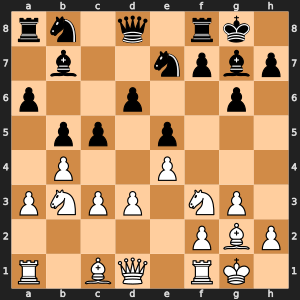

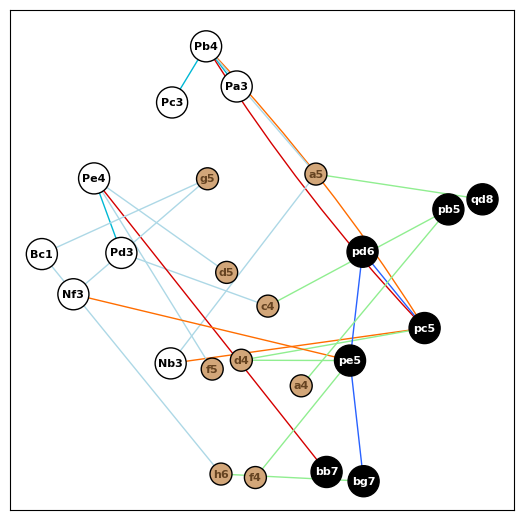

<Figure size 800x500 with 0 Axes>

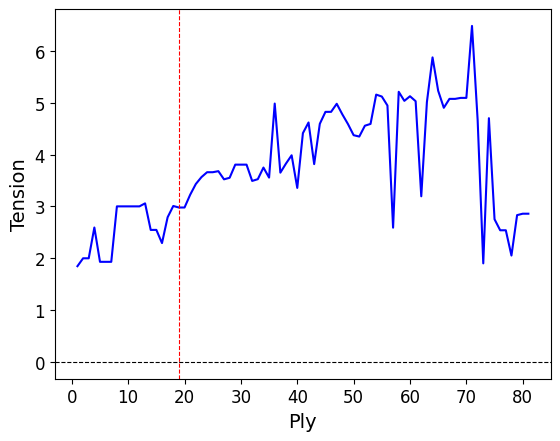

In [3]:
folder_path = r"C:\Users\Pc\Desktop\PHYTON\Chess\matches"

import statistics as st
import math




valori = []



for file_name in os.listdir(folder_path):

    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)

        

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:

                game = chess.pgn.read_game(f)
                break



i = 0

def euclidean_distance(p1, p2):
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

min_distance = 0.6
                

board = game.board()
values = []
board_states_before_move = []  # Store the board state **before** the move at each ply
board_states_after_move = []   # Store the board state **after** the move at each ply
moves = []  # To store the moves made
pieces_making_moves = []  # To store the piece making each move
key_pieces_under_attack = []  # To store the key piece under attack for each ply

for move in game.mainline_moves():
    # Store the piece making the move before pushing the move
    piece_making_move = board.piece_at(move.from_square)
    piece_symbol = f"{piece_making_move.symbol()}_{chess.square_name(move.from_square)}" if piece_making_move else None
    pieces_making_moves.append(piece_symbol)  # Store the piece symbol

    board_states_before_move.append(board.copy())  # Store board **before** the move
    board.push(move)  # Make the move
    board_states_after_move.append(board.copy())   # Store board **after** the move
    moves.append(move)  # Store the move

    # Compute the full interaction graph
    G_full = compute_full_interaction_graph(board)
    
    try:
        A = nx.adjacency_matrix(G_full).todense()

        # Calcola gli autovalori della matrice di adiacenza
        eigenvalues = np.linalg.eigvals(A)

        # Estrai il massimo autovalore
        max_eigenvalue = np.max(np.real(eigenvalues))
        
    except:
        max_eigenvalue = 0

    values.append(max_eigenvalue)
    
    if i == 20:
        print(values)
        svg_image = chess.svg.board(board=board, size=300)
        display(SVG(svg_image))  # Display the board
   
        # Save the SVG image to a file
        with open("chess_board.svg", "w") as f:
            f.write(svg_image)
            
        #g1 = compute_P(board)
    

        plt.figure(figsize=(6.5, 6.5))
        #pos = nx.bipartite_layout(G_full, g1[0])
        pos = nx.kamada_kawai_layout(G_full, scale=2)  # Prova con 2, 3, 5...
        
        import random
        
        
        
        
        posizioni = []


        for node in pos:
            x, y = pos[node]
            color = G_full.nodes[node].get('color', 'white').lower()
            if color == '#d2a679':
                cond = True
                j = 0
                while cond:
                    j +=1
                    pos[node] = (x + random.uniform(-0.6, 0.6), y + random.uniform(-0.6, 0.6))
                    if (all(euclidean_distance(pos[node], existing) >= min_distance for existing in posizioni)) | (j > 1000):
                        cond = False
                        posizioni.append(pos[node])
            else: 
                if node[0].isupper():
                    cond = True
                    j = 0
                    while cond:
                        j +=1
                        pos[node] = (x - 3 + random.uniform(-0.6, 0.6), y + random.uniform(-0.6, 0.6))
                        if (all(euclidean_distance(pos[node], existing) >= min_distance for existing in posizioni)) | (j > 1000):
                            cond = False
                            posizioni.append(pos[node])
                

                else:
        
                    cond = True
                    j = 0
                    while cond:
                        j +=1
                        pos[node] = (x + 3 + random.uniform(-0.6, 0.6), y + random.uniform(-0.6, 0.6))
                        if (all(euclidean_distance(pos[node], existing) >= min_distance for existing in posizioni)) | (j > 1000):
                            cond = False
                            posizioni.append(pos[node])


        widths = [G_full[u][v]['weight'] for u, v in G_full.edges]
        colors = [G_full[u][v]['color'] for u, v in G_full.edges]
        node_colors = [G_full.nodes[node].get('color', 'white') for node in G_full.nodes]
        node_sizes = [
    250 if color.lower() == '#d2a679' else 500
    for color in node_colors]
        
        # create the labels 
        label_colors = []
        for color in node_colors:
            if color == "black":
                label_colors.append("#ffffff")
            elif color == "#ffffff":
                label_colors.append("black")
            else:
                label_colors.append("#654321")
    
    
        
        
        
        
        # 1. Draw the nodes
        nx.draw_networkx_nodes(G_full, pos,
            node_size=node_sizes,
            node_color=node_colors,
            edgecolors='black',
            alpha=1
        )

        # 2. Draw the arcs, making them curved if width == 2
        for idx, (u, v) in enumerate(G_full.edges()):
            w = widths[idx]
            color = colors[idx]
            

            if w == 2:
                # Double curved arc: one positive, one negative.
                nx.draw_networkx_edges(G_full, pos,
                    edgelist=[(u, v)],
                    edge_color=color,
                    width=1,
                    alpha=1,
                    connectionstyle='arc3,rad=0.05',
                    arrows=True                   
                )
                
                
                if color == reds[0]:
                    color = reds[1]
                elif color == reds[1]:
                    color = reds[0]
                elif color == blues[0]:
                    color = blues[1]
                elif color == blues[1]:
                    color = blues[0]
                
                nx.draw_networkx_edges(G_full, pos,
                    edgelist=[(u, v)],
                    edge_color=color,
                    width=1,
                    alpha=1,
                    connectionstyle='arc3,rad=-0.05',
                    arrows=True 
                )
            else:
                # usual arc
                nx.draw_networkx_edges(G_full, pos,
                    edgelist=[(u, v)],
                    edge_color=color,
                    width=w,
                    alpha=1
                )
    
    
        # Prepare labels
        labels = {node: str(node) for node in G_full.nodes()}
        for i, node in enumerate(G_full.nodes()):
            nx.draw_networkx_labels(
                G_full, pos,
                labels={node: str(node)},
                font_color=label_colors[i],  # <--- label color opposite to the node
                font_size=8,
                font_weight='bold'
            )
        
        

        plt.savefig(r"C:\Users\Pc\Desktop\PHYTON\Chess\RISULTATI_17-03\chess_network4.png", dpi=1200, bbox_inches='tight')

    
    i += 1


plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
x = np.arange(1, len(values) + 1) 
ax.plot(x, values, label='Humans', color = "blue")


ax.set_xlabel('Ply', fontsize=14)
ax.set_ylabel('Tension', fontsize=14)


ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12) 

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.axvline(x=19, color='red', linestyle='--', linewidth=0.8)


plt.show()



# Separate matches in different files

In [ ]:
def split_pgn_file(l, input_pgn, output_folder):
    # Legge il file .pgn
    with open(input_pgn, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Separate games starting from "[Event"
    games = content.split("[Event")[1:]  # Avoid the first null value
    games = ["[Event" + game.strip() for game in games]  # Create each game

    # Create the output folder if it does not exist
    os.makedirs(output_folder, exist_ok=True)

    # Save each game in a separate file 
    j = 0
    for i, game in enumerate(games[:1200], start=0):
        output_file = os.path.join(output_folder, f"game_{j+1+l}.pgn")
        j += 1
        with open(output_file, "w", encoding="utf-8") as f:
            f.write(game + "\n")

# Stockfish games generation

In [ ]:
#!pip install stockfish
from stockfish import Stockfish
import chess.pgn
import random
import pandas as pd

stockfish = Stockfish(path=r"C:\...\stockfish-windows-x86-64-avx2.exe")

In [ ]:
N = 1

folder_path = r"C:\...\Humans"

import time

start_time = time.time()

# number of plies for the openings to copy
turns_to_skip = 12
i = 0

valori = []


v = 0
p = 0

for file_name in os.listdir(folder_path):
    i += 1
    if i <= 18:
        continue

    print(i)
    if file_name.endswith(".pgn"):
        file_path = os.path.join(folder_path, file_name)

        x = file_path.split("game_")[1].split(".pg")[0]
        print(x)

        # Detect file encoding
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding_info = chardet.detect(raw_data)
            detected_encoding = encoding_info['encoding']

        # Open and read the PGN file with the detected encoding
        with open(file_path, encoding=detected_encoding) as f:
            
            
                new_game = chess.pgn.Game()

                new_game.headers["Event"] = "Stockfish vs Stockfish"
                new_game.headers["White"] = "Stockfish"
                new_game.headers["Black"] = "Stockfish"
    

                game = chess.pgn.read_game(f)
                
                # Create the initial chessboard
                board = game.board()


                node = new_game
                old_node = game
                for _ in range(turns_to_skip):
                    if old_node.variations:
                        move = old_node.variations[0].move
                        board.push(move)
                        node = node.add_variation(move)  
                        old_node = old_node.variations[0]
                    else:
                        print(f"Errore: la partita non ha abbastanza mosse per arrivare alla mossa {turns_to_skip}.")
                        break

                
                # count the plies
                j = 0
                

                # play the game
                while not board.is_game_over():
                    
                    j += 1
                    
                    # chose the Stockfish depth
                    if board.turn == chess.WHITE:
                        depth = random.randint(23, 24)
                    else:
                        depth = random.randint(22, 23)

                    stockfish.set_depth(depth)
        
                    stockfish.set_fen_position(board.fen())
                    best_move = stockfish.get_best_move()
    
                    # Make the move on the chessboard
                    move = chess.Move.from_uci(best_move)
                    board.push(move)
                

                    node = node.add_variation(move)  
            

    
                # Save the game as a PGN file
                with open(r"C:\...\AI\match_" +  str(x) + ".pgn", "w", encoding="utf-8") as pgn_file:
                    new_game.accept(chess.pgn.FileExporter(pgn_file))
                
                end_time = time.time()
                print(f"Execution time: {end_time - start_time:.4f} seconds")    